## example_gridConverter_py 

This tutorial contains examples on how to convert sparse grids with a hierarchical basis to a sparse grid defined on the combination of anisotropic full grids (combination technique). It just includes grids without boundary points.

We distinguish between methods that convert (1) the anisotropic full grids to the hierarchical grids and (2) vice versa:

 - Converting the levels from the combination technique to the hierarchical version is always possible
   -> convertCombigridToHierarchicalSparseGrid

 - For spatially adaptive sparse grids it is possible that there exist just partially filled levels. Partially filled levels are not allowed in the combination technique. We, therefore, distinguish two cases where we

   - Add all levels where there exists at least one grid point in the hierarchical version
     -> convertHierarchicalSparseGridToCombigrid with conversion type GridConversionTypes_ALLSUBSPACES

   - Add just those levels where all the grid points in the hierarchical version exist 
     -> convertHierarchicalSparseGridToCombigrid with conversion type GridConversionTypes_COMPLETESUBSPACES

First, we import a the methods/classes we need for this example...

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

from pysgpp import CombigridOperation, multiFunc, DataVector, \
    CombigridMultiOperation, DataMatrix, SurplusRefinementFunctor, \
    Grid, convertCombigridToHierarchicalSparseGrid, convertHierarchicalSparseGridToCombigrid, \
    GridConversionTypes_ALLSUBSPACES, GridConversionTypes_COMPLETESUBSPACES, \
    createOperationHierarchisation, createOperationMultipleEval

... and define the function we want to interpolate. It is a parabola, which is zero for any $x_i=0$ and $x_i=1$ and evaluates to 1 for $x = (0.5, .., 0.5)^T$

In [8]:
def f(x):
    return np.prod([4 * xi * (1 - xi) for xi in x.array()])

### 1 Helper functions
We first define a few functions that remove boiler plate code from
the actual examples.

In [9]:
def interpolate(grid, f):
    """
    This helper functions cmoputes the coefficients of a sparse grid
    function for a given function

    Arguments:
    grid -- Grid sparse grid from pysgpp
    f -- function to be interpolated

    Return DataVector coefficients of the sparse grid function
    """
    gs = grid.getStorage()
    alpha = DataVector(gs.getSize())
    p = DataVector(gs.getDimension())
    for i in range(gs.getSize()):
        gs.getCoordinates(gs.getPoint(i), p)
        alpha[i] = f(p)
    createOperationHierarchisation(grid).doHierarchisation(alpha)
    return alpha

In [10]:
def refineGrid(grid, alpha, f, refnums):
    """
    This function refines a sparse grid function refnum times.

    Arguments:
    grid -- Grid sparse grid from pysgpp
    alpha -- DataVector coefficient vector
    f -- function to be interpolated
    refnums -- int number of refinement steps

    Return nothing
    """
    gs = grid.getStorage()
    gridGen = grid.getGenerator()
    x = DataVector(gs.getDimension())
    for _ in range(refnums):
        # refine a single grid point each time
        gridGen.refine(SurplusRefinementFunctor(alpha, 1))

        # extend alpha vector (new entries uninitialized)
        alpha.resizeZero(gs.getSize())

        # set function values in alpha
        for i in range(gs.getSize()):
            gs.getCoordinates(gs.getPoint(i), x)
            alpha[i] = f(x)

        # hierarchize
        createOperationHierarchisation(grid).doHierarchisation(alpha)

### 2 Regular sparse grids to regular combination technique and back

In this example we define a regular sparse grid function with a piecewise $d$-linear hat basis that interpolates the normal parabola. Then, we transform the sparse grid to the corresponding anisotropic grids in the combination technique and vice versa. We evaluate the resulting surrogates at numSamples randomly chosen samples on the unit hypercube and make sure that all of the surrogates we obtain by conversion are equal.

In [4]:
def regularGridToRegularGrid(numDims,
                             level,
                             f,
                             numSamples=1000,
                             plot=False,
                             verbose=False):
    """
    Converts a regular sparse grid function to a sparse grid in the
    combination technique and back.

    Arguments:
    numDims -- int number of dimensions
    level -- level of the sparse grid
    f -- function to be interpolated
    numSamples -- int number of random samples on which we evaluate the different sparse grid
                  functions to validate the grid conversion
    plot -- bool whether the sparse grid functions are plotted or not (just for numDims=1)
    verbose -- bool verbosity
    """
    ## We generate a iid of uniform samples, which we are going to use to
    ## validate the grid conversion
    x = np.random.rand(numSamples, numDims)
    parameters = DataMatrix(x)

    ## We create a regular sparse grid as usual.
    grid = Grid.createLinearGrid(numDims)
    grid.getGenerator().regular(level)
    alpha = interpolate(grid, f)

    ## We apply now both methods of the grid conversion.
    treeStorage_all = convertHierarchicalSparseGridToCombigrid(grid.getStorage(),
                                                               GridConversionTypes_ALLSUBSPACES)
    treeStorage_complete = convertHierarchicalSparseGridToCombigrid(grid.getStorage(),
                                                                GridConversionTypes_COMPLETESUBSPACES)

    ## Note, that we do the conversion just based on the grid points. With
    ## this approach you can easily use different basis function types on
    ## the same grid. We initialize the CombigridOperation on a grid that
    ## spans the same function space as the original hierarchical sparse
    ## grid: hat basis on an equidistant grids without boundary points.
    func = multiFunc(f)
    opt_all = CombigridMultiOperation.createExpUniformLinearInterpolation(numDims, func)
    opt_complete = CombigridMultiOperation.createExpUniformLinearInterpolation(numDims, func)

    ## The CombigridOperation expects the points at which you want to
    ## evaluate the interpolant as DataMatrix with the shape (numDims
    ## x numSamples). We, therefore, need to transpose the samples and
    ## initialize the multi operation with them. To set the level
    ## structure we initialize the level manager of the operation with
    ## the storage we have obtained after the conversion.
    parameters.transpose()
    opt_all.setParameters(parameters)
    opt_all.getLevelManager().addLevelsFromStructure(treeStorage_all)
    opt_complete.setParameters(parameters)
    opt_complete.getLevelManager().addLevelsFromStructure(treeStorage_complete)
    parameters.transpose()

    ## If you want you can examine the levels of the combination
    ## technique...
    if verbose:
        print("-" * 80)
        print("just full levels:")
        print(opt_complete.getLevelManager().getSerializedLevelStructure())
        print("-" * 80)
        print("all levels:")
        print(opt_all.getLevelManager().getSerializedLevelStructure())
        print("-" * 80)

    ## We start to transform the grids from the combination technique
    ## back to their hierarchical formulation. We, again, create a
    ## grid with a piecewise $d$-linear basis and initialize the grid
    ## points in its storage by the ones available in the levels of
    ## the combination technique. We do it first for the combination
    ## grids that just contain just those levels where the original
    ## sparse grid had complete subpsaces...
    grid_complete = Grid.createLinearGrid(numDims)
    treeStorage_complete = opt_complete.getLevelManager().getLevelStructure()
    convertCombigridToHierarchicalSparseGrid(treeStorage_complete, grid_complete.getStorage())

    ## ... and do the same for the version where we considered all
    ## subspaces where at least one grid point was located.
    grid_all = Grid.createLinearGrid(numDims)
    treeStorage_all = opt_all.getLevelManager().getLevelStructure()
    convertCombigridToHierarchicalSparseGrid(treeStorage_all, grid_all.getStorage())

    ## we interpolate now f on the new grids and...
    alpha_complete = interpolate(grid_complete, f)
    alpha_all = interpolate(grid_all, f)

    ## ... evaluate all the surrogate functions we have so far
    y_sg_regular = DataVector(numSamples)
    createOperationMultipleEval(grid, parameters).eval(alpha, y_sg_regular)

    y_sg_all = DataVector(numSamples)
    createOperationMultipleEval(grid_all, parameters).eval(alpha_all, y_sg_all)

    y_sg_complete = DataVector(numSamples)
    createOperationMultipleEval(grid_complete, parameters).eval(alpha_complete, y_sg_complete)

    y_ct_all = opt_all.getResult()
    y_ct_complete = opt_complete.getResult()

    ## For convenience we use flattened numpy arrays to test if the
    ## function values at each point are the same.
    y_sg_regular = y_sg_regular.array().flatten()
    y_ct_all = y_ct_all.array().flatten()
    y_ct_complete = y_ct_complete.array().flatten()
    y_sg_all = y_sg_all.array().flatten()
    y_sg_complete = y_sg_complete.array().flatten()

    ## If you want, you can plot the results if the problem is one dimensional
    if plot and numDims == 1:
        x = x.flatten()
        ixs = np.argsort(x)
        plt.figure()
        plt.plot(x[ixs], y_sg_regular[ixs], label="sg regular")
        plt.plot(x[ixs], y_sg_all[ixs], label="sg all")
        plt.plot(x[ixs], y_ct_complete[ixs], label="ct full")
        plt.plot(x[ixs], y_ct_all[ixs], label="ct all")
        plt.legend()
        plt.show()

    ## All the function values should be equivalent and...
    assert np.sum((y_ct_complete - y_ct_all) ** 2) < 1e-14
    assert np.sum((y_ct_complete - y_sg_regular) ** 2) < 1e-14
    assert np.sum((y_sg_regular - y_sg_all) ** 2) < 1e-14
    assert np.sum((y_sg_regular - y_sg_complete) ** 2) < 1e-14
    ## ... the grid sizes should as well
    assert grid_complete.getSize() == grid.getSize()
    assert grid_all.getSize() == grid.getSize()

In [5]:
regularGridToRegularGrid(numDims=4,
                         level=4,
                         f=f,
                         plot=True,
                         verbose=True)

--------------------------------------------------------------------------------
just full levels:
0, 0, 0, 0 -> 
0, 0, 0, 1 -> 
0, 0, 0, 2 -> 
0, 0, 0, 3 -> 
0, 0, 1, 0 -> 
0, 0, 1, 1 -> 
0, 0, 1, 2 -> 
0, 0, 2, 0 -> 
0, 0, 2, 1 -> 
0, 0, 3, 0 -> 
0, 1, 0, 0 -> 
0, 1, 0, 1 -> 
0, 1, 0, 2 -> 
0, 1, 1, 0 -> 
0, 1, 1, 1 -> 
0, 1, 2, 0 -> 
0, 2, 0, 0 -> 
0, 2, 0, 1 -> 
0, 2, 1, 0 -> 
0, 3, 0, 0 -> 
1, 0, 0, 0 -> 
1, 0, 0, 1 -> 
1, 0, 0, 2 -> 
1, 0, 1, 0 -> 
1, 0, 1, 1 -> 
1, 0, 2, 0 -> 
1, 1, 0, 0 -> 
1, 1, 0, 1 -> 
1, 1, 1, 0 -> 
1, 2, 0, 0 -> 
2, 0, 0, 0 -> 
2, 0, 0, 1 -> 
2, 0, 1, 0 -> 
2, 1, 0, 0 -> 
3, 0, 0, 0 -> 
--------------------------------------------------------------------------------
all levels:
0, 0, 0, 0 -> 
0, 0, 0, 1 -> 
0, 0, 0, 2 -> 
0, 0, 0, 3 -> 
0, 0, 1, 0 -> 
0, 0, 1, 1 -> 
0, 0, 1, 2 -> 
0, 0, 2, 0 -> 
0, 0, 2, 1 -> 
0, 0, 3, 0 -> 
0, 1, 0, 0 -> 
0, 1, 0, 1 -> 
0, 1, 0, 2 -> 
0, 1, 1, 0 -> 
0, 1, 1, 1 -> 
0, 1, 2,

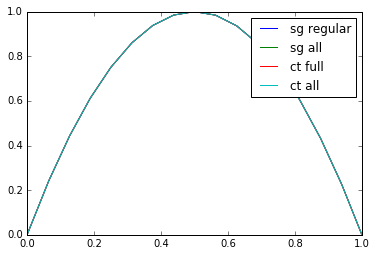

In [13]:
regularGridToRegularGrid(numDims=1,
                         level=4,
                         f=f,
                         plot=True,
                         verbose=False)


### 3 Spatially adaptive sparse grids to regular combination technique and back

In this example we define a spatially adaptive sparse grid function with a piecewise d-linear hat basis that interpolates the normal parabola. Then, we transform the sparse grid to the corresponding anisotropic grids in the combination technique and vice versa. We evaluate the resulting surrogates at numSamples randomly chosen samples on the unit hypercube. This time, the results differ depending on which conversion algorithm we use and on the completeness of the subpsaces.

In [6]:
def adaptiveGridToRegularGrid(numDims,
                              level,
                              refnums,
                              f,
                              numSamples=1000,
                              plot=False,
                              verbose=False):
    """
    Converts a regular sparse grid function to a sparse grid in the
    combination technique and back.

    Arguments:
    numDims -- int number of dimensions
    level -- level of the sparse grid
    refnums -- int number of refinement steps
    f -- function to be interpolated
    numSamples -- int number of random samples on which we evaluate the different sparse grid
                  functions to validate the grid conversion
    plot -- bool whether the sparse grid functions are plotted or not (just for numDims=1)
    verbose -- bool verbosity
    """
    ## We generate a iid of uniform samples, which we are going to use to
    ## validate the grid conversion
    x = np.random.rand(numSamples, numDims)
    parameters = DataMatrix(x)

    ## We create a regular sparse grid as usual and...
    grid = Grid.createLinearGrid(numDims)
    grid.getGenerator().regular(level)
    alpha = interpolate(grid, f)

    ## ... refine it adaptively
    grid_adaptive = grid.clone()
    alpha_adaptive = DataVector(alpha)
    refineGrid(grid_adaptive, alpha_adaptive, f, refnums)

    ## We apply now both methods of the grid conversion on the
    ## adaptively refined grid. The first conversion considers all
    ## levels where at least one sparse grid point exists, while the
    ## second one considers just complete subspaces.
    treeStorage_all = convertHierarchicalSparseGridToCombigrid(grid_adaptive.getStorage(),
                                                               GridConversionTypes_ALLSUBSPACES)
    treeStorage_complete = convertHierarchicalSparseGridToCombigrid(grid_adaptive.getStorage(),
                                                                GridConversionTypes_COMPLETESUBSPACES)

    ## We initialize the CombigridOperation on a grid that spans the
    ## same function space as the original hierarchical sparse grid:
    ## hat basis on an equidistant grids without boundary points.
    func = multiFunc(f)
    opt_all = CombigridMultiOperation.createExpUniformLinearInterpolation(numDims, func)
    opt_complete = CombigridMultiOperation.createExpUniformLinearInterpolation(numDims, func)

    ## The CombigridOperation expects the points at which you want to
    ## evaluate the interpolant as DataMatrix with the shape (numDims
    ## x numSamples). We, therefore, need to transpose the samples and
    ## initialize the multi operation with them. To set the level
    ## structure we initialize the level manager of the operation with
    ## the storage we have obtained after the conversion.
    parameters.transpose()
    opt_all.setParameters(parameters)
    opt_all.getLevelManager().addLevelsFromStructure(treeStorage_all)
    opt_complete.setParameters(parameters)
    opt_complete.getLevelManager().addLevelsFromStructure(treeStorage_complete)
    parameters.transpose()

    ## If you want you can examine the levels of the combination
    ## technique...
    if verbose:
        print("-" * 80)
        print("just full levels:")
        print(opt_complete.getLevelManager().getSerializedLevelStructure())
        print("-" * 80)
        print("all levels:")
        print(opt_all.getLevelManager().getSerializedLevelStructure())
        print("-" * 80)

    ## We start to transform the grids from the combination technique
    ## back to their hierarchical formulation. We, again, create a
    ## grid with a piecewise d-linear basis and initialize the grid
    ## points in its storage by the ones available in the levels of
    ## the combination technique. We do it first for the combination
    ## grids that just contain just those levels where the original
    ## sparse grid had complete subpsaces...
    grid_complete = Grid.createLinearGrid(numDims)
    treeStorage_complete = opt_complete.getLevelManager().getLevelStructure()
    convertCombigridToHierarchicalSparseGrid(treeStorage_complete, grid_complete.getStorage())

    ## ... and do the same for the version where we considered all
    ## subspaces where at least one grid point was located.
    grid_all = Grid.createLinearGrid(numDims)
    treeStorage_all = opt_all.getLevelManager().getLevelStructure()
    convertCombigridToHierarchicalSparseGrid(treeStorage_all, grid_all.getStorage())

    ## we interpolate now f on the new grids and...
    alpha_complete = interpolate(grid_complete, f)
    alpha_all = interpolate(grid_all, f)

    ## ... evaluate all the surrogate functions we have so far
    y_sg_regular = DataVector(numSamples)
    createOperationMultipleEval(grid, parameters).eval(alpha, y_sg_regular)

    y_sg_adaptive = DataVector(numSamples)
    createOperationMultipleEval(grid_adaptive, parameters).eval(alpha_adaptive, y_sg_adaptive)

    y_sg_all = DataVector(numSamples)
    createOperationMultipleEval(grid_all, parameters).eval(alpha_all, y_sg_all)

    y_sg_complete = DataVector(numSamples)
    createOperationMultipleEval(grid_complete, parameters).eval(alpha_complete, y_sg_complete)

    y_ct_all = opt_all.getResult()
    y_ct_complete = opt_complete.getResult()

    ## For convenience we use flattened numpy arrays to test if the
    ## function values at each point are the same.
    y_sg_regular = y_sg_regular.array().flatten()
    y_sg_adaptive = y_sg_adaptive.array().flatten()
    y_ct_all = y_ct_all.array().flatten()
    y_ct_complete = y_ct_complete.array().flatten()
    y_sg_all = y_sg_all.array().flatten()
    y_sg_complete = y_sg_complete.array().flatten()

    ## If you want, you can plot the results if the problem is one dimensional
    if plot and numDims == 1:
        x = x.flatten()
        ixs = np.argsort(x)
        plt.figure()
        plt.plot(x[ixs], y_sg_regular[ixs], label="sg regular")
        plt.plot(x[ixs], y_sg_adaptive[ixs], label="sg adaptive")
        plt.plot(x[ixs], y_ct_complete[ixs], label="ct full")
        plt.plot(x[ixs], y_ct_all[ixs], label="ct all")
        plt.plot(x[ixs], y_sg_complete[ixs], label="sg full")
        plt.plot(x[ixs], y_sg_all[ixs], label="sg all")
        plt.legend()
        plt.show()

    ## All the function values should not be equivalent if...
    if grid_complete.getSize() < grid_all.getSize():
        assert np.sum((y_ct_complete - y_ct_all) ** 2) > 1e-14
        assert np.sum((y_sg_regular - y_sg_all) ** 2) > 1e-14

    ## and should be equivalent if...
    if grid_complete.getSize() == grid.getSize():
        assert np.sum((y_ct_complete - y_sg_regular) ** 2) < 1e-14
        assert np.sum((y_sg_complete - y_sg_regular) ** 2) < 1e-14

    ## For the grid sizes it must hold that
    assert grid_adaptive.getSize() > grid.getSize()
    assert grid_complete.getSize() <= grid_adaptive.getSize()
    assert grid_all.getSize() >= grid.getSize()


In [14]:
adaptiveGridToRegularGrid(numDims=4,
                          level=4,
                          refnums=1,
                          f=f,
                          plot=True,
                          verbose=False)